<a href="https://colab.research.google.com/github/MikePham05/Thyroid-segmentation/blob/main/Thyroid_Segementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importing packages

Installing segmentation package


Mounting drive, where the data is. Drive is at manhpn75@gmail.com

In [ ]:
!pip install -U git+https://github.com/qubvel/segmentation_models.pytorch
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
from PIL import Image
from torchvision import transforms
import os
from torch.utils.data import Dataset as BaseDataset
from torch.utils.data import DataLoader
import torch
import numpy as np
import segmentation_models_pytorch as smp
from torch.utils.data.sampler import SubsetRandomSampler

  Cloning https://github.com/qubvel/segmentation_models.pytorch to /tmp/pip-req-build-xdfwdeto
  Running command git clone -q https://github.com/qubvel/segmentation_models.pytorch /tmp/pip-req-build-xdfwdeto
     |████████████████████████████████| 61kB 3.1MB/s 
     |████████████████████████████████| 245kB 5.8MB/s 
  Created wheel for segmentation-models-pytorch: filename=segmentation_models_pytorch-0.1.3-cp37-none-any.whl size=83164 sha256=9837db4e78803469f8368b0e52ff128fd9172427035bd538e59ef8161f810405
  Stored in directory: /tmp/pip-ephem-wheel-cache-_9pnf_79/wheels/79/3f/09/1587a252e0314d26ad242d6d2e165622ab95c95e5cfe4b942c
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp37-none-any.whl size=60963 sha256=a27cce36948827020112bf5a77bbd03728a62932f27999bb61bd1713ce32bfa9
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.6.3-cp37-non

In [ ]:
class Dataset(BaseDataset):
    """
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
    """

    def __init__(
            self,
            images_dir,
            masks_dir,
            transform=None
    ):
        self.ids = sorted(os.listdir(images_dir))
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        self.transform = transform

    def __getitem__(self, i):
        # read data
        image = Image.open(self.images_fps[i])
        mask = Image.open(self.masks_fps[i])
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        return image, mask

    def __len__(self):
        return len(self.ids)


# Data set
input_dir = "/content/drive/MyDrive/data/images"
output_dir = "/content/drive/MyDrive/data/masks_inverted"
data = Dataset(input_dir,
               output_dir,
               transform=transforms.Compose([transforms.Resize([224, 224]),
                                             transforms.Grayscale(num_output_channels=1),
                                             transforms.ToTensor()
                                             ]))

# Randomly divide dataset into 3 sets of roughly 60/20/20 training, validating, testing
validation_split = 0.2
shuffle_dataset = True
random_seed = 42
data_size = len(data)
indices = list(range(data_size))
split = int(np.floor(validation_split * data_size))
if shuffle_dataset:
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_val_indices, test_indices = indices[split:], indices[:split]
split_train_val = int(np.floor(validation_split * len(train_val_indices)))
train_indices, val_indices = train_val_indices[split_train_val:], train_val_indices[:split_train_val]

# Creating sampler and loaders
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)
test_sampler = SubsetRandomSampler(test_indices)

train_loader = DataLoader(data, batch_size=30, sampler=train_sampler)
validation_loader = DataLoader(data, batch_size=30, sampler=val_sampler)
test_loader = DataLoader(data, sampler=test_sampler)

In [ ]:
import matplotlib.pyplot as plt
def visualization(i):
  x, y = data.__getitem__(i)
  x = np.array(x)
  y = np.array(y)
  x = np.reshape(x, (224,224))
  y = np.reshape(y, (224,224))
  f, axarr = plt.subplots(1,2)
  axarr[0].imshow(x, cmap='gray', vmin=0, vmax=1)
  axarr[1].imshow(y, cmap='gray', vmin=0, vmax=1)

def visualization_tensor(t0, t1):
  x = np.array(t0)
  x = np.reshape(x, (224, 224))
  y = np.array(t1)
  y = np.reshape(y, (224, 224))
  f, axarr = plt.subplots(1, 2)
  axarr[0].imshow(x, cmap='gray', vmin = 0, vmax = 1)
  axarr[1].imshow(y, cmap='gray', vmin = 0, vmax = 1)

In [ ]:
ENCODER = 'densenet121'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['thyroid']
ACTIVATION = 'sigmoid'  # could be None for logits or 'softmax2d' for multicalss segmentation

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER,
    in_channels=1,
    encoder_weights=ENCODER_WEIGHTS,
    classes=len(CLASSES),
    activation=ACTIVATION,
)


preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

# Modify training parameters
loss = smp.utils.losses.DiceLoss()
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

optimizer = torch.optim.Adam([
    dict(params=model.parameters(), lr=0.001),
])

Downloading: "http://data.lip6.fr/cadene/pretrainedmodels/densenet121-fbdb23505.pth" to /root/.cache/torch/hub/checkpoints/densenet121-fbdb23505.pth


In [ ]:
model = torch.load('/content/drive/MyDrive/Thyroid models/Unet_densenet121.pth')
optimizer.param_groups[0]['lr'] = 0.001

In [ ]:
# Epochs runner
train_epoch = smp.utils.train.TrainEpoch(
    model,
    loss=loss,
    metrics=metrics,
    optimizer=optimizer,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss,
    metrics=metrics,
    verbose=True,
)

# Training process


max_score = 0

for i in range(0, 40):
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(validation_loader)

    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, '/content/drive/MyDrive/Thyroid models/Unet_densenet121.pth')
        print('Model saved!')

    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')

In [ ]:
# evaluate model on test set
test_epoch = smp.utils.train.ValidEpoch(
    model=model,
    loss=loss,
    metrics=metrics,
)

logs = test_epoch.run(test_loader)

valid: 100%|██████████| 393/393 [06:16<00:00,  1.04it/s, dice_loss - 0.2612, iou_score - 0.629]


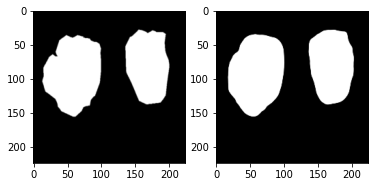

In [ ]:
n = np.random.choice(len(test_indices))
image, true_mask = data[n]
predicted_mask = model.predict(image.unsqueeze(0))
visualization_tensor(true_mask, predicted_mask)